In [53]:
from pyqlearning.annealingmodel.simulated_annealing import SimulatedAnnealing
from pyqlearning.annealingmodel.cost_functionable import CostFunctionable
from devsample.maze_greedy_q_learning import MazeGreedyQLearning
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pydbm.activation.logistic_function import LogisticFunction

In [2]:
# The number of records.
map_row = 25
# The number of columns.
map_col = 25

# `#` is wall in maze.
# `S` is a start point.
# `G` is a goal.
# `@` is the agent.
start_point_label, end_point_label, wall_label, agent_label = ("S", "G", "#", "@")

In [3]:
# The reward values can be generated by random sampling.
real_map_arr = np.random.normal(5, 2, size=(map_row, map_col))
real_map_arr = np.round(real_map_arr, 1)

map_arr = real_map_arr.astype(object)

# For visualization.
real_map_arr = map_arr[1:map_row-1, 1:map_row-1]
real_map_arr = real_map_arr.astype(np.float64)

# For learning.
map_arr[:, 0] = wall_label
map_arr[0, :] = wall_label
map_arr[-1, :] = wall_label
map_arr[:, -1] = wall_label
map_arr[map_row-2, map_col-2] = end_point_label
map_arr[1, 1] = start_point_label

In [4]:
# The start point.
real_map_arr[0, 0] = -1.0
# The end point(Goal).
real_map_arr[map_row-3, map_col-3] = -1.0

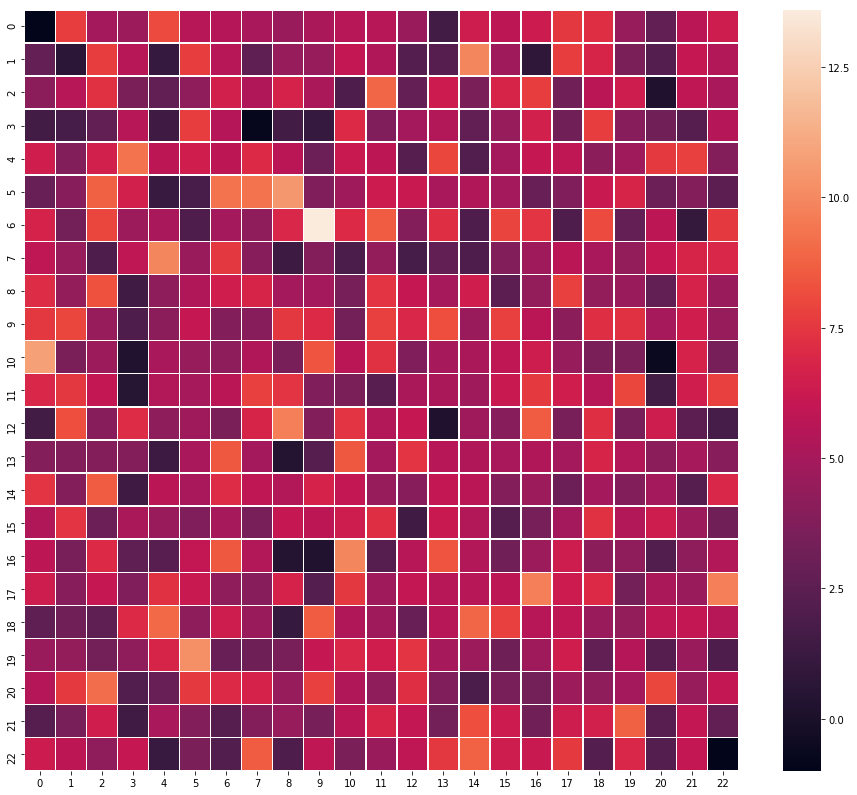

In [5]:
fig = plt.figure(figsize=(16, 14))
sns.heatmap(real_map_arr, linewidths=.5)
plt.show();plt.close()

In [6]:
class iPyMazeGreedyQLearning(MazeGreedyQLearning):
    def visualize_learning_result(self, state_key):
        '''
        Visualize learning result.
        
        Override.
        '''
        # Default function of this method is to print the maze searched by agent.
        # But it is not important for Jupyter notebook users in this prototype.
        # Jupyter notebook allow users to create beautiful visualizations.

        #Then,
        pass

In [59]:
class MazeSearchingCost(CostFunctionable):

    __inferenced_result_list_list = []

    def __init__(self, map_arr, start_point_label, end_point_label, wall_label, agent_label):
        self.__map_arr = map_arr
        self.__start_point_label = start_point_label
        self.__end_point_label = end_point_label
        self.__wall_label = wall_label
        self.__agent_label = agent_label
        self.__sigmoid = LogisticFunction()
    
    def compute(self, x):
        greedy_rate = float(x[0])
        alpha_value = float(x[1])
        gamma_value = float(x[2])
        limit = 1000

        # Instantiation.
        maze_q_learning = iPyMazeGreedyQLearning()
        # Set the parameters.
        maze_q_learning.epsilon_greedy_rate = greedy_rate
        maze_q_learning.alpha_value = alpha_value
        maze_q_learning.gamma_value = gamma_value

        # Setup.
        maze_q_learning.initialize(
            map_arr=self.__map_arr,
            start_point_label=self.__start_point_label,
            end_point_label=self.__end_point_label,
            wall_label=self.__wall_label,
            agent_label=self.__agent_label
        )
        # Learning.
        maze_q_learning.learn(state_key=(1, 1), limit=limit)
        
        # Inference an optimal route in this maze map by Q-values.
        # [(x, y, Q-Value)]
        inferenced_result_list = maze_q_learning.inference(limit=100)
        result_arr = np.array(inferenced_result_list)
        result_arr[:, 2] = np.nan_to_num(result_arr[:, 2])
        cost_performance = np.array([result_arr[:, 2].mean()])
        cost_performance = 1 - self.__sigmoid.activate(cost_performance)
        self.__inferenced_result_list_list.append(inferenced_result_list)
        return cost_performance

    def get_inferenced_result_list(self):
        return self.__inferenced_result_list

    def set_readonly(self, value):
        raise TypeError
    
    inferenced_result_list = property(get_inferenced_result_list, set_readonly)


In [60]:
greedy_rate_arr = np.random.uniform(low=0.5, high=0.7, size=1000)
alpha_value_arr = np.random.uniform(low=0.3, high=0.7, size=1000)
gamma_value_arr = np.random.uniform(low=0.3, high=0.7, size=1000)
cost_arr = np.c_[greedy_rate_arr, alpha_value_arr, gamma_value_arr]

In [61]:
cost_functionable = MazeSearchingCost(
    map_arr, 
    start_point_label, 
    end_point_label, 
    wall_label, 
    agent_label
)
annealing_model = SimulatedAnnealing(
    cost_functionable=cost_functionable,
    cycles_num=33,
    trials_per_cycle=3,
    accepted_sol_num=0.0,
    init_prob=0.7,
    final_prob=0.001,
    start_pos=0,
    move_range=3
)

In [62]:
annealing_model.fit_dist_mat(cost_arr)

In [63]:
annealing_model.annealing()

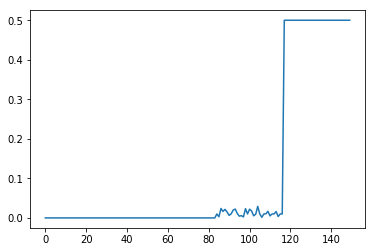

In [68]:
# cost_arr , delta_e, delta_e_avg, p, int(accept)
predicted_log_list = annealing_model.predicted_log_list
predicted_log_arr = np.array(predicted_log_list)
# cost
plt.plot(predicted_log_arr[-150:, 0])
plt.show()
plt.close()

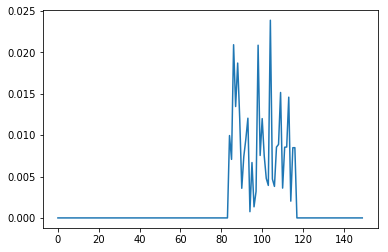

In [69]:
# delta_e
plt.plot(predicted_log_arr[-150:, 1])
plt.show()
plt.close()

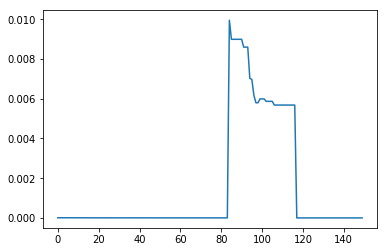

In [70]:
# delta_e_avg
plt.plot(predicted_log_arr[-150:, 2])
plt.show()
plt.close()

In [67]:
# greedy_rate, alpha_value, gamma_value
annealing_model.x[np.argmin(predicted_log_arr[:, 1])]

array([ 0.54675836,  0.53279006,  0.34435479])